In [7]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn import cluster
import matplotlib.pyplot as plt
from scipy import ndimage, signal
from skimage import color, morphology, filters, segmentation, util, transform
import time

In [34]:
images_path = os.path.join('dataset', 'images')
DS = pd.read_csv(os.path.join('dataset', 'dataset.csv'))

def get(filename):
    return np.array(Image.open(os.path.join(images_path, filename)))

def kurtosis(x):
    mean = np.mean(x)
    return len(x)*np.sum((x - mean)**4)/np.sum((x - mean)**2)**2

def skewness(x):
    mean = np.mean(x)
    n = len(x)
    return 1/n * np.sum((x - mean)**3)/(np.sum((x - mean)**2)/(n - 1))**(3/2)

def minimum(img, k=3):
    data = img.flatten()
    kmeans = cluster.KMeans(k)
    cluster_id = kmeans.fit_predict(data.reshape(-1, 1))
    _min = None
    metrics = None
    for i in np.unique(cluster_id):
        subset = data[cluster_id == i]
        hist, bins = np.histogram(subset, bins=50)
        if _min == None or bins.max() < _min: 
            _min = subset.max()
            metrics = (kurtosis(subset), skewness(subset))
    return _min, metrics

def mask(img):
    return ndimage.binary_dilation(ndimage.binary_opening(ndimage.binary_opening(img, iterations=5), iterations=10), iterations=10)

def fft2d(image):
    return np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(image)))

def peaks_filter(x, y, peaks, k=1):
    ypeaks = y[peaks]
    xpeaks = x[peaks]
    max_peak = peaks[ypeaks == ypeaks.max()]
    for _ in range(k-1):
        max_peak = peaks[ypeaks == ypeaks[np.isin(ypeaks, y[x < x[max_peak][0]])].max()]
    return max_peak

def freq_peaks(image):
    fft = np.abs(fft2d(image))
    xfreqs = np.fft.ifftshift(np.fft.fftfreq(fft.shape[0], 1))
    yfreqs = np.fft.ifftshift(np.fft.fftfreq(fft.shape[1], 1))
    
    ymean = np.mean(fft, axis=1)
    xmean = np.mean(fft, axis=0)
    
    (ypeaks, _), (xpeaks, _) = signal.find_peaks(ymean), signal.find_peaks(xmean)
    Py = peaks_filter(yfreqs, ymean, ypeaks, 2)
    Px = peaks_filter(xfreqs, xmean, xpeaks, 2)
    
    return np.abs(xfreqs[Px][0]), np.abs(xfreqs[Py][0])

'''def predict_area_simple(image):
    img = color.rgb2gray(image)
    img_var = var(img)
    m, kur = minimum(img_var)
    S = mask(img_var < m)
    fx, fy = freq_peaks(gray_image)
    return np.sum(S)*fx*fy, kur'''

def predict_area(image):
    img = color.rgb2gray(image)
    img_var = variance(filters.farid(img))
    m, metrics = minimum(img_var)
    S = mask(img_var < m)
    fx, fy = freq_peaks(img)
    return np.sum(S)*fx*fy, metrics

def normalize(x, i=0, f=1):
    return i + (f - i)/(x.max() - x.min()) * (x - x.min())

def entropy(img, r=3):
    return filters.rank.entropy(util.img_as_ubyte(normalize(img, -1, 1)), morphology.disk(3))

def rescale(img, fmin, fmax):
    return fmin + (img - img.min())*(fmax - fmin)/(img.max() - img.min())

In [35]:
%%time
predict, process_time, kur, skew = [], [], [], []
total = len(DS)
start = None
for i, filename in enumerate(DS.filename):
    start = time.time()
    
    area, (k, sk) = predict_area(get(filename))
    predict.append(area)
    kur.append(k)
    skew.append(sk)
    
    process_time.append(time.localtime(time.time() - start).tm_sec)
    tpi = np.mean(process_time)
    print(f'{i+1}/{total}|{(i/total*100):.2f}%|PI: {tpi:.1f}sec|ET: {tpi*(total-i-1)/60:.1f}min'+' '*10, end='\r')

CPU times: total: 6min 47sET: 0.0min          
Wall time: 6min 34s


In [36]:
DS['predict'] = predict
DS['kur'] = kur
DS['skew'] = skew
DS['process_time'] = process_time
DS['disp'] = DS.area - DS.predict
DS['error_abs'] = np.abs(DS.disp)
DS['error_rel'] = DS.error_abs/DS.area*100

In [28]:
dss = DS.sort_values('area')

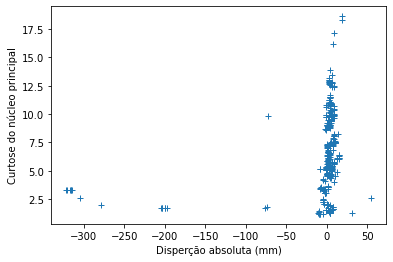

In [29]:
plt.plot(dss.disp, dss.kur, '+')
plt.xlabel('Disperção absoluta (mm)')
plt.ylabel('Curtose do núcleo principal')
plt.show()

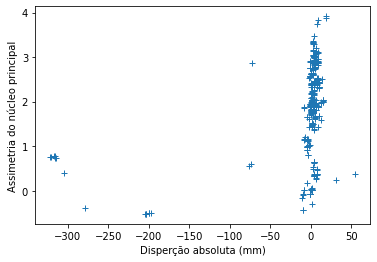

In [30]:
plt.plot(dss.disp, dss['skew'], '+')
plt.xlabel('Disperção absoluta (mm)')
plt.ylabel('Assimetria do núcleo principal')
plt.show()

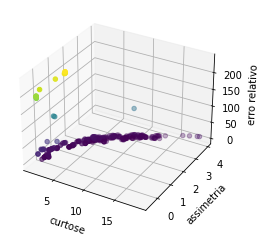

In [31]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(dss.kur, dss['skew'], dss.error_rel, c=dss.error_rel)

ax.set_xlabel('curtose')
ax.set_ylabel('assimetria')
ax.set_zlabel('erro relativo')

plt.show()

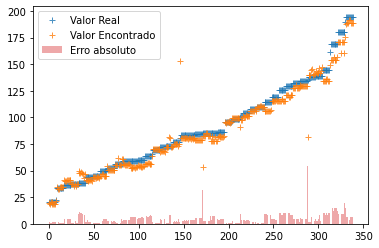

In [37]:
#t = np.arange(len(DS))
F = dss.error_rel < 100
plt.plot(dss[F].area.values, '+', alpha=0.8, label='Valor Real')
plt.plot(dss[F].predict.values, '+', alpha=0.8, label='Valor Encontrado')
plt.bar(range(len(dss[F])), dss[F].error_abs, color='tab:red', alpha=0.4, label='Erro absoluto')
plt.legend()
    
plt.show()

In [38]:
dss.describe()

,area,predict,kur,skew,process_time,disp,error_abs,error_rel
count,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000
mean,91.496442,99.361432,6.282629,1.857108,0.042254,-7.864989,15.449356,14.617950
std,41.634421,71.421655,3.482625,0.992821,0.201451,53.852907,52.180567,42.383177
min,20.623000,18.730164,1.188176,-0.521603,0.000000,-321.333459,0.175930,0.163140
25%,59.068000,54.751953,3.468608,1.285450,0.000000,0.358370,1.885901,2.678713
50%,84.957000,81.462250,5.712558,1.986161,0.000000,2.863045,3.875873,4.537061
75%,125.983000,120.155899,8.943752,2.607114,0.000000,5.486264,7.447391,8.105656
max,194.683000,456.970459,18.629033,3.917106,1.000000,54.174750,321.333459,236.906935


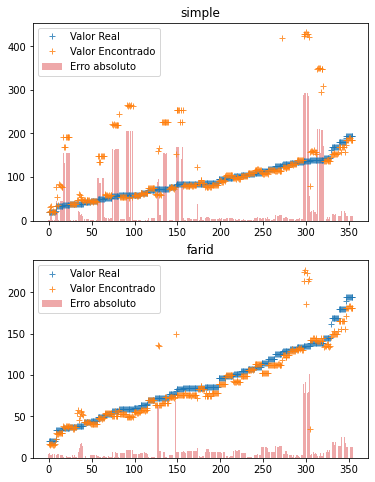

In [16]:
fig, axs = plt.subplots(2, 1, figsize=(6, 8))
dss = DS.sort_values('area')

t = np.arange(len(DS))
start = time.time()
for i, meth in enumerate(('simple', 'farid')):
    axs[i].set_title(meth)
    axs[i].plot(dss.area.values, '+', alpha=0.8, label='Valor Real')
    axs[i].plot(dss[meth].values, '+', alpha=0.8, label='Valor Encontrado')
    axs[i].bar(t, np.abs(dss.area.values - dss[meth].values), color='tab:red', alpha=0.4, label='Erro absoluto')
    axs[i].legend()
    
plt.show()

In [14]:
np.abs(DS[['simple_rel', 'farid_rel']]).describe()

,simple_rel,farid_rel
count,355.000000,355.000000
mean,53.099729,9.533687
std,99.803864,12.669246
min,0.141565,0.061668
25%,3.186902,2.898300
50%,6.177884,7.393119
75%,17.189458,10.381565
max,426.894750,89.620884
